In [1]:
import numpy as np 
import pandas as pd 
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
from datetime import datetime
%matplotlib inline 

# fig_size = plt.rcParams["figure.figsize"] 
# fig_size[0] = 12 
# fig_size[1] = 12 
plt.rcParams["figure.figsize"] = (12,12) 

from sklearn import model_selection 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing # for scale
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

import pickle
import importlib

import finalproj as fp
import corinne

In [2]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

In [3]:
features_train = np.array(pickle.load(open('features_train', 'rb')))
labels_train = np.array(pickle.load(open('labels_train', 'rb')))
print(len(features_train), len(labels_train))

4320 4320


In [4]:
X_scaled = preprocessing.scale(features_train)
X_scaled.shape

(4320, 2048)

_Pick two classes of your choice from the dataset. Train an L2-regularized logistic regression classiﬁer on the training set using your own fast gradient algorithm with λ = 1. Plot, with diﬀerent colors, the misclassiﬁcation error on the training set and on the validation set vs iterations._

I'll pick 086, Pacific Loon, and 087, Mallard, as the two classes.

Per Zaid's answer on 5/27, in this problem I'm considering just the subset of the data that has these two classes. I pull the data and train/test a binary classifer. I only use the 60 observations for the two chosen birds.

In [5]:
indices_twoclasses = np.where((labels_train == '086.Pacific_Loon') | (labels_train == '087.Mallard'))
indices_twoclasses

(array([1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690,
        1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701,
        1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712,
        1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723,
        1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734,
        1735, 1736, 1737, 1738, 1739]),)

In [6]:
X_twoclasses = X_scaled[indices_twoclasses]
X_twoclasses.shape

(60, 2048)

In [7]:
y_twoclasses = np.where(labels_train[indices_twoclasses] == '086.Pacific_Loon', 1, -1)
y_twoclasses.shape

(60,)

In [8]:
def get_probability(logodds):
    return 1 / (1 + np.exp(-logodds))
    #return np.exp(logodds) / (1 + np.exp(logodds))

def get_accuracy(beta_coefs, X, y_actual, prob_threshold=0.5):
    """
    Return the classification accuracy given a set of coefficients, in 
    beta_coefs, and observations, in X, compared to actual/known values 
    in y_actual. The threshold parameter defines the value above which the
    predicted value is considered a positive example.
    """
    y_pred = X.dot(beta_coefs.T).ravel() # ravel to convert to vector
    
    # for logistic regression convert to a prob and use a prob threshold
    probs = get_probability(y_pred)
    y_thresholded = np.where(probs > prob_threshold, 1, -1)
    
    return accuracy_score(y_actual, y_thresholded)

In [9]:
X_twoclasses_train, X_twoclasses_test, y_twoclasses_train, y_twoclasses_test = model_selection.train_test_split(
    X_twoclasses, y_twoclasses, test_size=0.3)
X_twoclasses_train.shape, X_twoclasses_test.shape, y_twoclasses_train.shape, y_twoclasses_test.shape

((42, 2048), (18, 2048), (42,), (18,))

In [10]:
t_init = 0.01
max_iters = 100

In [11]:
results = fp.fastgradalgo(
    X_twoclasses_train, y_twoclasses_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=max_iters)
results[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
98,-0.005726,0.000066,0.006333,-0.003782,-0.002165,-0.000351,-0.004308,0.000136,0.002686,-0.003865,...,-0.004532,-0.000521,0.002923,-0.007327,0.003977,0.007526,-0.010347,-0.005934,-0.001916,0.003730
99,-0.005726,0.000066,0.006333,-0.003783,-0.002165,-0.000351,-0.004310,0.000136,0.002686,-0.003867,...,-0.004532,-0.000522,0.002923,-0.007326,0.003977,0.007527,-0.010347,-0.005934,-0.001916,0.003729
100,-0.005726,0.000066,0.006334,-0.003784,-0.002166,-0.000351,-0.004311,0.000136,0.002686,-0.003868,...,-0.004532,-0.000523,0.002923,-0.007326,0.003977,0.007527,-0.010347,-0.005933,-0.001916,0.003729


In [12]:
# note use of the held out test data to get the performance metrics
accuracy = get_accuracy(fp.get_final_coefs(results), X_twoclasses_test, y_twoclasses_test)
print("Accuracy: {0:.1%}".format(accuracy))
print("Misclassification error: {0:.1%}".format(1 - accuracy))

Accuracy: 100.0%
Misclassification error: 0.0%


In [13]:
def get_objective_values(beta_results_df, X, y, lam):
    return beta_results_df.apply(lambda r: fp.compute_objective_logistic_regression(r.values, 
                                                    X, y, lam), axis=1)

In [14]:
obj_vals = pd.DataFrame({'Train': get_objective_values(results, X_twoclasses_train, y_twoclasses_train, 1),
              'Validation': get_objective_values(results, X_twoclasses_test, y_twoclasses_test, 1)})
obj_vals[:3]

,Train,Validation
0,0.693147,0.693147
1,0.247721,0.328401
2,0.135823,0.170312


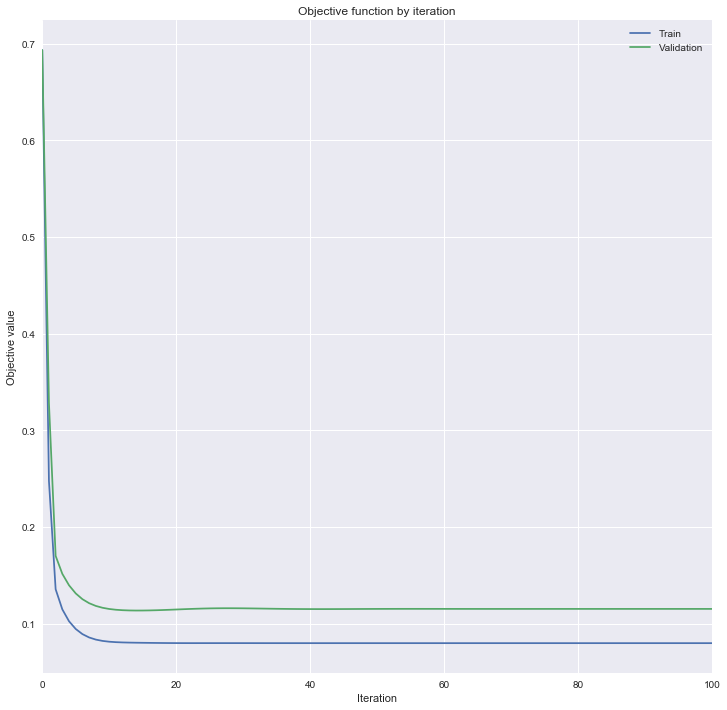

In [15]:
ax = obj_vals.plot()
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective value')
ax.set_title('Objective function by iteration')

In [16]:
def get_misclassification_errors(beta_results_df, X, y):
    return beta_results_df.apply(lambda r: 1 - get_accuracy(r.values, X, y), axis=1)

In [17]:
errors = pd.DataFrame({'Train': get_misclassification_errors(results, X_twoclasses_train, y_twoclasses_train),
              'Validation': get_misclassification_errors(results, X_twoclasses_test, y_twoclasses_test)})
errors[:3]

,Train,Validation
0,0.452381,0.611111
1,0.095238,0.111111
2,0.047619,0.000000


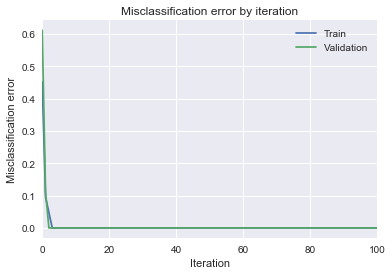

In [18]:
ax = errors.plot()
ax.set_xlabel('Iteration')
ax.set_ylabel('Misclassification error')
ax.set_title('Misclassification error by iteration')

## Corinne verification - using her code, do we see the same results?

In [19]:
results_corinne, thetas_corinne = corinne.fastgradalgo(np.zeros(X_train.shape[1]),
                                       np.zeros(X_train.shape[1]),
                                       1,
                                       0.01,
                                       100,
                                       X_train,
                                       y_train)
results_corinne.shape

NameError: name 'X_train' is not defined

In [20]:
results_corinne

NameError: name 'results_corinne' is not defined

In [21]:
corinne.objective_plot(results_corinne, 1, X_train, y_train)

NameError: name 'results_corinne' is not defined

In [22]:
corinne.compute_misclassification_error(results_corinne[100,:], X_test, y_test)

NameError: name 'results_corinne' is not defined

In [23]:
corinne.compute_misclassification_error(results.values[100,:], X_test, y_test)

NameError: name 'X_test' is not defined

In [24]:
results_corinne[2,:]

NameError: name 'results_corinne' is not defined

In [25]:
results.values[2, :]

array([-0.00333503,  0.00057126,  0.00208173, ..., -0.00391905,
       -0.00173726,  0.00095118])

In [26]:
lambduh = 1
d = X_train.shape[1]
beta_init = np.zeros(d)
theta_init = np.zeros(d)
eta_init = 1/(scipy.linalg.eigh(1/len(y_train)*X_train.T.dot(X_train), 
                                eigvals=(d-1, d-1), eigvals_only=True)[0]+lambduh)
maxiter = 300
#betas_grad = corinne.graddescent(beta_init, lambduh, eta_init, maxiter, X_train, y_train)
betas_fastgrad, thetas_fastgrad = corinne.fastgradalgo(beta_init, theta_init, lambduh, eta_init, maxiter,
                                                       X_train, y_train)
betas_fastgrad.shape
#objective_plot(betas_grad, betas_fastgrad, lambduh, save_file='hw3_q1_part_h_output.png')


NameError: name 'X_train' is not defined

In [27]:
betas_fastgrad[-1:]

NameError: name 'betas_fastgrad' is not defined

In [28]:
corinne.compute_misclassification_error(betas_fastgrad[-1,:], X_test, y_test)

NameError: name 'betas_fastgrad' is not defined

Ok, so, bottom line, we get the same results from our code as we do from Corinne's code, even when we use the exact same setup/init code (for ex, that sets eta_init using X.T.dot(X)), and when we use Corinne's code that does backtracking compared to our code, above, where we're not using backtracking. I think this is good enough for me to accept that w/ a lambda of 1 at least, logistic regression is way worse than just returning negative all the time.

What do we see when we use our backtracking impl?

In [29]:
results = fp.fastgradalgo(
    X_train, y_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=100)
results[-3:]

NameError: name 'X_train' is not defined

In [30]:
results = fp.fastgradalgo(
    X_train, y_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=1, max_iter=300, t_func=fp.backtracking)
results[-3:]

NameError: name 'X_train' is not defined

In [31]:
corinne.compute_misclassification_error(results.values[-1,:], X_test, y_test)

NameError: name 'X_test' is not defined

In [32]:
1 - get_accuracy(results.values[-1,:], X_test, y_test)

NameError: name 'X_test' is not defined

Ok, so we get the same results w/ our own backtracking implementation. Note again that since our stopping criteria is _only_ the number of iterations, we don't automatically get any benefit from the improved step sizes that backtracking gives us. That said, we still in theory could get to the minimum faster, which means if we're manually setting max_iter based on experimentation, then backtracking could help.

Finally, it's possible that backtracking adds enough processing time that we might want to run w/ it off if we're not going to use it. 

Although, backtracking might not _just_ give us better steps sizes leading to quicker convergence. It seems like it could also help us avoid the case where we _don't_ converge, if it keeps us from using a static/single step size that at some point means we're moving back and forth on our objective value without decreasing.

Bottom line, if i care, I should probably benchmark, and watch for non-convergence being fixed when we use backtracking. I'll keep that in mind.

Also, separately, it seems like my impl is way faster than Corinne's - I can run w/ 300 iterations in just a few secs while it takes her's well more than 10-20s it seems, anecdotally. It might be interesting to profile and see if a) this is really the case, and b) if so, why.

In [33]:
corinne.objective_plot(results.values, 1, X_train, y_train)

NameError: name 'X_train' is not defined

In [34]:
[fp.compute_objective_logistic_regression(coefs, X_train, y_train, 1) for coefs in results.values][:10]

NameError: name 'X_train' is not defined

_Find the value of the regularization parameter λ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an L2-regularized logistic regression classiﬁer on the training set using your own fast gradient algorithm with that value of λ found by cross-validation. Plot, with diﬀerent colors, the misclassiﬁcation error on the training set and on the validation set vs iterations._

In [35]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

In [36]:
lambdas = [10 ** exponent for exponent in range(-5,2)]
lambdas

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [37]:
lams, scores = fp.cross_validate(10, X_twoclasses_train, y_twoclasses_train, lambdas, max_iters=100)

In [38]:
list(zip(lams, scores))

[(1e-05, 1.0),
 (0.0001, 1.0),
 (0.001, 1.0),
 (0.01, 1.0),
 (0.1, 1.0),
 (1, 1.0),
 (10, 0.95500000000000007)]

In [39]:
results_best = fp.fastgradalgo(
    X_twoclasses_train, y_twoclasses_train, t_init=t_init, 
    grad_func = fp.compute_gradient_logistic_regression, 
    obj_func = fp.compute_objective_logistic_regression, 
    lam=0, max_iter=max_iters)
results_best[-3:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
98,-0.017001,0.001543,0.010858,-0.010831,-0.002946,-0.001579,-0.006491,0.002654,0.000364,-0.008531,...,-0.007823,0.001720,0.012890,-0.031864,0.016663,0.023430,-0.024498,-0.038940,-0.007316,0.010297
99,-0.017045,0.001548,0.010883,-0.010866,-0.002948,-0.001584,-0.006525,0.002646,0.000367,-0.008564,...,-0.007850,0.001728,0.012931,-0.031972,0.016698,0.023511,-0.024565,-0.039056,-0.007330,0.010338
100,-0.017089,0.001552,0.010909,-0.010900,-0.002950,-0.001590,-0.006559,0.002638,0.000370,-0.008597,...,-0.007876,0.001735,0.012973,-0.032078,0.016733,0.023592,-0.024631,-0.039172,-0.007344,0.010378


In [40]:
fp.get_accuracy(fp.get_final_coefs(results_best), X_twoclasses_test, y_twoclasses_test)

1.0

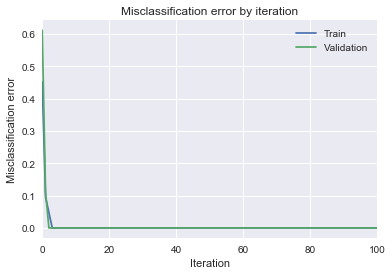

In [41]:
fp.plot_misclassification_errors_by_iteration(results_best, X_twoclasses_train, X_twoclasses_test, 
                                              y_twoclasses_train, y_twoclasses_test)

# Homework five

In [192]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

_Pick k = 5 classes of your choice from the dataset. You may choose any subset of 5 classes among all classes of the dataset._

In [50]:
classifier_labels = ['086.Pacific_Loon','044.Frigatebird','095.Baltimore_Oriole',
                     '154.Red_eyed_Vireo','188.Pileated_Woodpecker']

_Write a function that, for any class at hand, creates a training set with an equal number of examples from the class at hand and from the other classes. You may simply randomly pick the examples from the other classes._

In [48]:
X_incl086_train, X_incl086_test, labels_incl086_train, labels_incl086_test = fp.get_train_tst_balanced_set('086.Pacific_Loon', X_scaled, labels_train)
y_incl086_train = np.where(labels_incl086_train == '086.Pacific_Loon', 1, -1)
X_incl086_train.shape, y_incl086_train.shape

((42, 2048), (42,))

_For each class c, train an L2-regularized logistic regression classiﬁer using your own fast gradient algorithm with λc = 1. Display the confusion matrix. Which classes seem to be the most diﬃcult to classify?_

In [63]:
error_rate, cm, actual_labels, predicted_labels = fp.get_results_for_lambdas(classifier_labels, X_scaled, 
                                                        labels_train, np.ones(5), random_state=100)
error_rate

0.088888888888888906

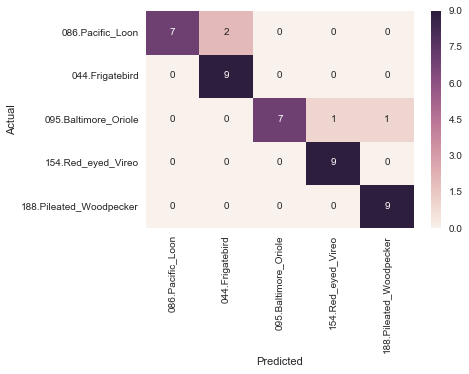

In [64]:
fp.plot_multiclass_confusion_matrix(cm, classifier_labels)

If we look at individual confusion matrices for each classifier, why do we always get a 0 in one corner? This means that we never have any false negatives - that is, we never predict -1 when it's actually 1. We do the other three. Why?

So, this means that we never predict that it ISN'T the bird in question, when it is actually the bird in question. I tried w/ an array of thresholds from very low to very high, and while they changed some true negatives to false positives, they never changed any prediction to a false negative. Perhaps this is something that's not uncommon when you have a single 1-vs-rest classifier? For example, that classifier tends to see anything at all that looks remotely like the bird in question as the bird in question (leading to true positives when it IS the bird, and false positives when it's not), but does not - generally, or at all? - think that the bird in question is actually NOT the bird in question. I could also write the above or add in terms of precision and recall if I thought about it for a few more minutes.

_Write a function that returns the ranked list of classes in terms of classiﬁcation diﬃculty using the confusion matrix. Compute the multi-class misclassiﬁcation error._

In [65]:
test_results_df = pd.DataFrame({'Actual': actual_labels,
                                'Predicted': predicted_labels})
test_results_df[:2]

,Actual,Predicted
0,086.Pacific_Loon,086.Pacific_Loon
1,086.Pacific_Loon,086.Pacific_Loon


In [66]:
accuracy_by_class = test_results_df.groupby(['Actual']).agg(lambda g: 1 - accuracy_score(g['Actual'], g['Predicted']))
accuracy_by_class.rename(columns={'Predicted': 'Misclassification error'}, inplace=True)
accuracy_by_class.sort_values(['Misclassification error'], ascending=False, inplace=True)

accuracy_by_class

,Misclassification error
Actual,
044.Frigatebird,0.222222
095.Baltimore_Oriole,0.222222
086.Pacific_Loon,0.000000
154.Red_eyed_Vireo,0.000000
188.Pileated_Woodpecker,0.000000


In [68]:
print("Overall multi-class misclassification error: {:.1%}".format(1 - accuracy_score(actual_labels, predicted_labels)))

Overall multi-class misclassification error: 8.9%


_Find the values of the regularization parameters λ1,...,λk for the classiﬁers using a hold-out validation set strategy. Deﬁne a grid of values Λ for each parameter λc with c = 1,...,k. For each setting of the regularization parameters λ1,...,λk, where each λc can take values in Λ (independently), train all your k = 5 classiﬁers and save the multi-class misclassiﬁcation error on the validation set for each setting of the regularization parameters λ1,...,λk._

**TODO** write code that creates a grid and runs for each combo, and then that outputs and saves the misclassification error.

In [174]:
lambdas = [10 ** exponent for exponent in range(-3,1)]
lambdas

[0.001, 0.01, 0.1, 1]

In [175]:
lambda_combinations = list(itertools.product(lambdas, repeat=5))
len(lambda_combinations)

1024

In [176]:
lambda_combinations[:3]

[(0.001, 0.001, 0.001, 0.001, 0.001),
 (0.001, 0.001, 0.001, 0.001, 0.01),
 (0.001, 0.001, 0.001, 0.001, 0.1)]

In [105]:
[fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, lams)[0] for lams in lambda_combinations[:3]]

[0.19999999999999996, 0.28888888888888886, 0.17777777777777781]

In [141]:

type(errors)

list

**TODO** Need to create train/test sets - one for each label, I think - OUTSIDE the get_results call, and pass it in, so each set of lambdas gets a chance w/ the same set of train and test data. (Might also speed things up at least a little bit, since we won't have to get new sets each time.) 

In [162]:
print("Started at {}.".format(datetime.now()))

misclassification_errors = []

try:
    for index, lams in enumerate(lambda_combinations[:10]):
        if (index % 10 == 0):
            print('Processing lambdas with index {}...'.format(index))

        error = fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, lams)[0]
        misclassification_errors.append(error)

except:
    raise()
finally:
    print("Finished at {}. Processed {} sets of lambdas".format(datetime.now(), index+1))

Started at 2017-05-28 22:34:33.608803.
Processing lambdas with index 0...
Finished at 2017-05-28 22:35:13.140013. Processed 10 sets of lambdas


In [163]:
misclassification_errors.sort()
misclassification_errors

[0.044444444444444398,
 0.044444444444444398,
 0.088888888888888906,
 0.11111111111111116,
 0.22222222222222221,
 0.24444444444444446,
 0.24444444444444446,
 0.24444444444444446,
 0.31111111111111112,
 0.33333333333333337]

In [166]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [211]:
def get_misclassification_error_for_lambdas(lambdas):
    return lambdas, fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, lambdas)[0]

# uses already-set (global - boo!) sets_per_labels, since this doesn't change at all for all the runs
# and to avoid having to update to take a tuple/deal with multiple arg unpacking (for now at least)
def get_misclassification_error_for_lambdas_with_shared_sets(lambdas):
    return lambdas, fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, lambdas,
                                               sets_for_labels=sets_per_labels)[0]

def create_and_run_jobs(lambda_combinations, worker_job):
    with ThreadPoolExecutor(max_workers=10) as executor:
         return executor.map(worker_job, lambda_combinations)

In [206]:
print("Started at {}.".format(datetime.now()))

all_results = []

results = create_and_run_jobs(lambda_combinations[:3], get_misclassification_error_for_lambdas)
for result in results:
    all_results.append(result)
    
print("Finished at {}. Processed {} sets of lambdas.".format(datetime.now(), len(all_results)))

Started at 2017-05-29 09:47:55.743522.
Finished at 2017-05-29 09:48:03.926263. Processed 3 sets of lambdas.


In [204]:
all_results

[((0.001, 0.001, 0.001, 0.001, 0.001), 0.26666666666666672),
 ((0.001, 0.001, 0.001, 0.001, 0.01), 0.26666666666666672),
 ((0.001, 0.001, 0.001, 0.001, 0.1), 0.17777777777777781)]

In [182]:
#pickle.dump(all_results, open('all_results', 'wb'))

In [191]:
foo = [error for _, error in all_results]
foo.sort()
foo

[0.022222222222222254,
 0.022222222222222254,
 0.022222222222222254,
 0.022222222222222254,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.044444444444444398,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.066666666666666652,
 0.06666666

And now, with the ability to generate the train-test sets just once, so that a) most importantly, each fastgradalgo run gets to use the same particular set of train/test data, so one doesn't have an easier or harder time than another, and b) it might be at least a bit faster since we only have to generate the train-test data once rather than for each of the runs for a set of five lambdas.

In [210]:
# the worker func requires the train-test sets to pointed to by the sets_per_labels variable - argh, global state (see above)
sets_per_labels = [fp.get_train_tst_balanced_set(classifier_label, X_scaled, labels_train) for classifier_label in classifier_labels]
len(sets_per_labels)

5

In [218]:
print("Started at {}.".format(datetime.now()))

all_results_shared_sets = []

results = create_and_run_jobs(lambda_combinations, get_misclassification_error_for_lambdas_with_shared_sets)
for result in results:
    all_results_shared_sets.append(result)
    
print("Finished at {}. Processed {} sets of lambdas.".format(datetime.now(), len(all_results_shared_sets)))

Started at 2017-05-29 09:56:55.569739.
Finished at 2017-05-29 10:41:34.992012. Processed 1024 sets of lambdas.


In [238]:
all_results_shared_sets[:3]

[((0.001, 0.001, 0.001, 0.001, 0.001), 0.1333333333333333),
 ((0.001, 0.001, 0.001, 0.001, 0.01), 0.22222222222222221),
 ((0.001, 0.001, 0.001, 0.001, 0.1), 0.26666666666666672)]

In [220]:
#pickle.dump(all_results_shared_sets, open('all_results_shared_sets', 'wb'))

In [262]:
results[4]

(array([ 0.01509434,  0.00552825,  0.0055491 , ..., -0.00297287,
        -0.00921239, -0.00852349]),
 array([[ 5.09265533,  4.20112905, -1.62171833, ..., -0.215201  ,
         -1.41351453, -0.17103363],
        [ 0.11460979,  5.61620863, -1.14607335, ...,  1.44764577,
         -0.16874614, -1.23431923],
        [-0.82787628,  0.08774076, -1.29261557, ...,  0.44963873,
         -0.9061965 ,  0.15335795],
        ..., 
        [-0.44432821,  0.64231437, -0.54492884, ..., -0.64411074,
         -0.62482926, -0.34675179],
        [-0.30679252, -0.10385079, -0.42422159, ..., -0.29760614,
         -0.73200947,  0.17702185],
        [-1.47711076, -0.03799772, -1.30542734, ...,  0.90678552,
         -0.56708922,  0.16192286]]),
 array(['188.Pileated_Woodpecker', '188.Pileated_Woodpecker',
        '188.Pileated_Woodpecker', '188.Pileated_Woodpecker',
        '188.Pileated_Woodpecker', '188.Pileated_Woodpecker',
        '188.Pileated_Woodpecker', '188.Pileated_Woodpecker',
        '188.Pileated_W

In [263]:
foo, bar, baz = zip(*results)

In [266]:
baz

(array(['086.Pacific_Loon', '086.Pacific_Loon', '086.Pacific_Loon',
        '086.Pacific_Loon', '086.Pacific_Loon', '086.Pacific_Loon',
        '086.Pacific_Loon', '086.Pacific_Loon', '086.Pacific_Loon'], 
       dtype='<U29'),
 array(['044.Frigatebird', '044.Frigatebird', '044.Frigatebird',
        '044.Frigatebird', '044.Frigatebird', '044.Frigatebird',
        '044.Frigatebird', '044.Frigatebird', '044.Frigatebird'], 
       dtype='<U29'),
 array(['095.Baltimore_Oriole', '095.Baltimore_Oriole',
        '095.Baltimore_Oriole', '095.Baltimore_Oriole',
        '095.Baltimore_Oriole', '095.Baltimore_Oriole',
        '095.Baltimore_Oriole', '095.Baltimore_Oriole',
        '095.Baltimore_Oriole'], 
       dtype='<U29'),
 array(['154.Red_eyed_Vireo', '154.Red_eyed_Vireo', '154.Red_eyed_Vireo',
        '154.Red_eyed_Vireo', '154.Red_eyed_Vireo', '154.Red_eyed_Vireo',
        '154.Red_eyed_Vireo', '154.Red_eyed_Vireo', '154.Red_eyed_Vireo'], 
       dtype='<U29'),
 array(['188.Pileated_Woodp

In [643]:
importlib.reload(fp)
importlib.reload(corinne)

<module 'corinne' from '/Users/andrewenfield/work/github/Data558/Kaggle/corinne.py'>

_Find the optimal value of the regularization parameters λ1,...,λk based on the validation error. Display the confusion matrix for this setting of the regularization parameters._

In [241]:
sorted(all_results_shared_sets, key=lambda t: t[1])[:3]

[((1, 1, 1, 1, 1), 0.088888888888888906),
 ((0.01, 0.01, 1, 0.01, 0.01), 0.11111111111111116),
 ((0.01, 0.01, 1, 0.1, 0.01), 0.11111111111111116)]

In [244]:
# So, here's the best lambda values:
lambdas_best = sorted(all_results_shared_sets, key=lambda t: t[1])[0][0]
lambdas_best

(1, 1, 1, 1, 1)

In [ ]:
# and we'll get the coefs/get the classifier (we didn't save the coef values from the run, so 
# will get them now)
results = [fp.get_classifier_for_label(classifier_label, X_scaled, labels_train, lam, sets_for_this_label) for
                                 classifier_label, lam, sets_for_this_label in zip(classifier_labels, lambdas_best, sets_for_labels)]
#final_coefs, X_test, labels_test = results
len(results)

In [ ]:
misclassification_error, cm, _, _ = fp.get_results_for_lambdas(classifier_labels, X_scaled, labels_train, 
                                                               lambdas_best, sets_for_labels=sets_per_labels)
misclassification_error

In [ ]:
fp.plot_multiclass_confusion_matrix(cm, classifier_labels)

# Homework Seven

_In this exercise, you are going to train support vector machines (SVMs) using scikit-learn and the data competition project dataset. You will consider here all classes in the dataset. You may work on this exercise on your own computer ﬁrst. Note, however, that you need AWS to run the experiments for the last two parts of this exercise._

## Warm up

_In a one-vs-one fashion, for each pairs of classes, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-one fashion._

In [16]:
len(X_scaled)

4320

In [17]:
X_scaled[:10,:3].shape

(10, 3)

In [18]:
# how_many = 30 * 144
# num_of_features = 256
# %time ovo = OneVsOneClassifier(LinearSVC(random_state=0), n_jobs=-1).fit(X_scaled[:how_many, :num_of_features], labels_train[:how_many])

CPU times: user 16 s, sys: 1.89 s, total: 17.9 s
Wall time: 26.2 s


In [19]:
# how_many_predict = 30 * 144
# %time accuracy_score(labels_train[:how_many_predict], ovo.predict(X_scaled[:how_many_predict, :num_of_features]))

CPU times: user 1min 23s, sys: 33.7 s, total: 1min 56s
Wall time: 1min 50s


1.0

Ok, so from trying above with num_of_features = 2, the absolute minimum time this could take - on my laptop - is about 5s for training 144 choose 2 classifiers, and 11s to predict 4.3k results using these classifiers, WHEN using only two features (instead of 2048). This compares to about 6-7hrs for all 2048 features, judging from the experience of others. If I bump this up to 10 features, it takes 6s to train and 13s to predict. With 30 features, 5s to train and 18s to predict. 64 features: 7s to train, 33s to predict. 256 features: 22.6s to train, 1:48 to predict.

I'll give 256 features a try, with PCA.

In [20]:
num_of_pca_components = 256

pca = PCA(n_components=num_of_pca_components)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(4320, 256)

In [21]:
# how much variance can we explain w/ all of the components?
np.cumsum(pca.explained_variance_ratio_)[-1:]

array([ 0.85799174])

In [ ]:
how_many = 30 * 144
%time ovo_pca = OneVsOneClassifier(LinearSVC(random_state=0), n_jobs=-1).fit(X_pca[:how_many], labels_train[:how_many])

CPU times: user 14.4 s, sys: 1.67 s, total: 16.1 s
Wall time: 22.7 s


In [ ]:
how_many_predict = 30 * 72
%time accuracy_score(labels_train[:how_many_predict], ovo_pca.predict(X_pca[:how_many_predict, :num_of_features]))

With a 128 component PCA, 11s to train and 42s to predict 4.3k observations. With a 256 component PCA, 25s to train and 90s to predict. I get 76% of variance explained with 128 components compared to 86% of variance explained with 256 components. It looks like predicting is linear as predicting half the observations with 256 components instead of the full 4.3k takes 44s (instead of 90). 

The training time is small (25s) and I won't be predicting a full 4.3k likely, as I'll probably only predict on a hold out set, so I could go ahead with 256 components for now. That said, do I really care about the accuracy? Not really - I'll go with 128 and bump it up later if I have to.

So, we need a train/test split so we can compute the misclassification accuracy all up.

In [ ]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = model_selection.train_test_split(X_pca, labels_train, random_state=42)
X_pca_train.shape, X_pca_test.shape, y_pca_train.shape, y_pca_test.shape

In [ ]:
ovo_pca = OneVsOneClassifier(LinearSVC(random_state=0), n_jobs=-1).fit(X_pca_train, y_pca_train)

In [ ]:
ovo_pca_predicted_values = ovo_pca.predict(X_pca_test)

In [ ]:
1 - accuracy_score(y_pca_test, ovo_pca_predicted_values)

In [ ]:
cm = confusion_matrix(y_pca_test, ovo_pca_predicted_values)
cm

In [ ]:
fp.plot_multiclass_confusion_matrix(cm, np.unique(labels_train))

With 128 components, I get a misclassification error of 34%. With 256 components, I get a misclassification error of 33%. This at least says it's cool to stay with 128 components.

_In a one-vs-rest fashion, for each class, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for λc. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-rest fashion._

_Using the option multi class=’crammer singer’ in scikitlearn’s function LinearSVC, train a multi-class linear SVM classiﬁer using the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using this multiclass linear SVM classiﬁer._

## Linear SVMs for multi-class classiﬁcation

_Redo all questions above now tuning the regularization parameters using cross-validation._

_In a one-vs-one fashion, for each pairs of classes, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-one fashion._

_In a one-vs-rest fashion, for each class, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for λc. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-rest fashion._

_Using the option multi class=’crammer singer’ in scikitlearn’s function LinearSVC, train a multi-class linear SVM classiﬁer using the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using this multiclass linear SVM classiﬁer._

## Kernel SVMs for multi-class classiﬁcation

_Redo all questions above now using the polynomial kernel of order 2 (and tuning the regularization parameters using cross-validation)._

_In a one-vs-one fashion, for each pairs of classes, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-one fashion._

_In a one-vs-rest fashion, for each class, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for λc. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-rest fashion._

_Using the option multi class=’crammer singer’ in scikitlearn’s function LinearSVC, train a multi-class linear SVM classiﬁer using the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using this multiclass linear SVM classiﬁer._